# IMPORTS, FUNCTIONS AND OTHER STATIC STUFF

In [1]:
from lime import our_lime
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from skimage.segmentation import mark_boundaries
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

### STATIC PATHS ###
ROOT_DIR = Path.cwd()
CAT_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'cat'
DOG_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'dog'
CATVSDOG_CLASSIFIER_WEIGHT_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'catvdog.pth'
ROOT_DIR = Path.cwd()

classes = ["Cat", "Dog"]

### COMPUTE DEVICE (CPU/GPU) ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### FUNCTIONS ###
def get_image(path):
    #randomly pick a dog or cat image from image folder
    img_files = list(path.glob('*.jpg*'))
    img_file = random.choice(img_files)
    img_path_file = path / img_file
    with open(os.path.abspath(img_path_file), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
    
#check if paths are valid
if not Path(CAT_IMG_PATH):
    print(f"Warning: The cat image directory was not found:\n{CAT_IMG_PATH}")
if not Path(DOG_IMG_PATH):
    print(f"Warning: The dog image directory was not found:\n{DOG_IMG_PATH}")
if not Path(CATVSDOG_CLASSIFIER_WEIGHT_PATH):
    print(f"Warning: The blackbox classifier weights were not found:\n{BLACKBOX_CLASSIFIER_WEIGHT_PATH}")

Device: cuda


# Demo: ImageObject Class

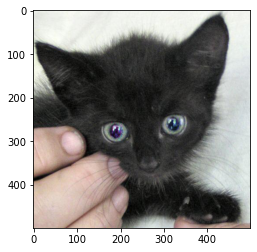

In [2]:
#pick random cat image
random_cat_image = get_image(CAT_IMG_PATH)
ImageObjectDemo = our_lime.ImageObject(random_cat_image)
ImageObjectDemo.show()

# Demo: SegmentationMethod Class

In [3]:
explainer = our_lime.Explainer(
    our_lime.SegmentationMethod("quickshift")
)
explainer.segment_image(ImageObjectDemo, kernel_size=4, max_dist=200, ratio=0.2 )
#superpixels are saved
ImageObjectDemo.superpixels

array([[  6,   6,   6, ...,   2,   2,   2],
       [  6,   6,   6, ...,   2,   2,   2],
       [  6,   6,   6, ...,   2,   2,   2],
       ...,
       [151, 151, 151, ..., 146, 146, 146],
       [151, 151, 151, ..., 146, 146, 146],
       [151, 151, 151, ..., 146, 146, 146]], dtype=int64)

# Demo: Generate Mask

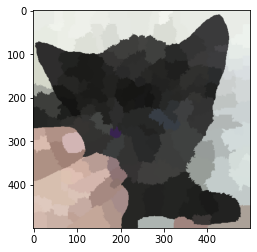

In [4]:
#set mask to to average superpixel value
explainer.mask_image(ImageObjectDemo)
plt.imshow(ImageObjectDemo.masked_image)

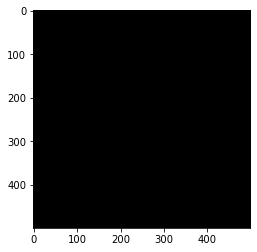

In [5]:
#set mask value to 0
explainer.mask_image(ImageObjectDemo, mask_value = 0)
plt.imshow(ImageObjectDemo.masked_image)

# Demo: Sample Superpixels

In [6]:
#create 3 samples
sampled_images = explainer.sample_superpixels(ImageObjectDemo, 3)

<class 'list'>
<class 'numpy.ndarray'>
(500, 499, 3)


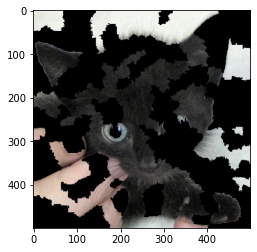

In [7]:
print(type(sampled_images))
#showing first sample
print(type(sampled_images[0]))
print(np.shape(sampled_images[0]))
plt.imshow(sampled_images[0])

# Demo: BlackBox IO

In [9]:
#load CatVsDog weights into densenet architecture.
checkpoint = torch.load(CATVSDOG_CLASSIFIER_WEIGHT_PATH, map_location='cpu')
model = models.densenet121(pretrained=False)
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))
model.parameters = checkpoint['parameters']
model.load_state_dict(checkpoint['state_dict'])
for param in model.parameters():
    param.requires_grad = False

#the data transformation used when training the CatVsDog classifier
def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf

preprocess_transform = get_preprocess_transform()
blackbox_io = explainer.map_blaxbox_io(sampled_images, model, preprocess_transform)
#list of tuples. Each tuple (pertubated sample, blackbox output)
print(type(blackbox_io))
print(len(blackbox_io))
print(blackbox_io)

<class 'list'>
3
[(array([[[231, 233, 228],
        [232, 234, 229],
        [234, 236, 231],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[232, 234, 229],
        [233, 235, 230],
        [235, 237, 232],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[235, 237, 232],
        [236, 238, 233],
        [237, 239, 234],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
     